
# 问题2：美国关税调整对美日汽车贸易与区域结构的影响
- **数据来源**：`问题二数据` 下的关税、全球追踪、美日双边贸易、进口结构与渗透率、墨西哥产能及出口、贸易逆差等文件。
- **目标**：刻画美国对日整车关税由 2.5% 提至 28% 的情景（互惠关税），量化对美日汽车贸易、美国进口结构和本土汽车产业的传导效应，并给出包含非关税应对（产地转移/标准认证）的策略框架。
- **核心方程**：
  - 价格传导：$P_1 = P_0 (1 + \gamma\,\Delta \tau)$。
  - 需求弹性：$Q_1 = Q_0\,[1 + \epsilon\,(\Delta P/P_0)]$。
  - 产地转移（逻辑）：$s_{reloc} = \min\big(\kappa,\,\frac{1}{1+e^{-k(\Delta\tau-\tau^*)}}\big)$，$\kappa$ 为产能约束。
  - 进口渗透率传导：$\pi_1 = \pi_0\,[1 + \theta\,\epsilon\,(\Delta P/P_0)]$，$\theta$ 表示价格对渗透率的传导系数。


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.dpi": 110})


def get_data_root() -> Path:
    candidates = [
        Path.cwd() / "问题二数据",
        Path.cwd().parent / "问题二数据",
    ]
    for cand in candidates:
        if cand.exists():
            return cand
    raise FileNotFoundError(f"Cannot find 数据目录, tried: {candidates}")

data_root = get_data_root()


def pct_to_float(x: str) -> float:
    """Convert '24.8%' or '0-2.5%' strings to decimals."""
    if pd.isna(x):
        return np.nan
    x = str(x).strip().replace("%", "")
    if "-" in x:
        parts = [p for p in x.split("-") if p]
        vals = [float(p) for p in parts if p.replace(".", "", 1).isdigit()]
        return np.mean(vals) / 100 if vals else np.nan
    try:
        return float(x) / 100
    except ValueError:
        return np.nan


def cagr(series: pd.Series) -> float:
    """Compound annual growth rate for an ordered Series."""
    series = series.dropna()
    if len(series) < 2:
        return 0.0
    start, end = series.iloc[0], series.iloc[-1]
    years = len(series) - 1
    if start <= 0:
        return 0.0
    return (end / start) ** (1 / years) - 1


def extend_one(series: pd.Series) -> float:
    """Project one step forward using CAGR."""
    g = cagr(series)
    return series.iloc[-1] * (1 + g)


In [2]:

# 读入“问题二数据”
us_tariff = pd.read_csv(data_root / "✅关税与贸易政策数据" / "✅美国对日本汽车及零部件的关税税率（2025调整后）" / "1.csv")
global_tariff = pd.read_csv(data_root / "✅宏观贸易与经济数据" / "✅全球汽车贸易关税追踪数据" / "1.csv")
import_penetration = pd.read_csv(data_root / "✅美日汽车贸易与市场结构数据" / "✅美国汽车市场进口渗透率（2024-2025）" / "1.csv")
import_structure = pd.read_csv(data_root / "✅美日汽车贸易与市场结构数据" / "✅美国汽车进口结构（分国家，品牌，车型占比）" / "1.csv")
mexico_facilities = pd.read_csv(data_root / "✅日本车企非关税应对措施数据" / "✅日本车企在墨西哥等国的生产布局，产能及对美出口量" / "1.csv")
trade_balance = pd.read_csv(data_root / "✅宏观贸易与经济数据" / "✅美日贸易逆差（汽车及零部件分项）" / "1.csv")

# 美日双边进出口额
raw_import = pd.read_csv(data_root / "✅美日汽车贸易与市场结构数据" / "✅美日汽车双边进出口额，数量（分车型 品牌）" / "import.csv", header=None)
raw_export = pd.read_csv(data_root / "✅美日汽车贸易与市场结构数据" / "✅美日汽车双边进出口额，数量（分车型 品牌）" / "export.csv", header=None)
bilateral_import = pd.DataFrame({"Year": raw_import.iloc[0, 1:].astype(int), "US_import_from_Japan": raw_import.iloc[1, 1:].astype(float)})
bilateral_export = pd.DataFrame({"Year": raw_export.iloc[0, 1:].astype(int), "Japan_export_to_US": raw_export.iloc[1, 1:].astype(float)})

# 清洗与单位换算
us_tariff["rate"] = us_tariff["US_Tariff_Rate"].apply(pct_to_float)
import_penetration["penetration"] = import_penetration["Import_Penetration_Rate"].apply(pct_to_float)
import_structure["Import_Value_USD"] = pd.to_numeric(import_structure["Import_Value_USD"], errors="coerce")
mexico_facilities["Annual_Production_Capacity"] = pd.to_numeric(mexico_facilities["Annual_Production_Capacity"], errors="coerce")
mexico_facilities["Exports_to_USD"] = pd.to_numeric(mexico_facilities["Exports_to_USD"], errors="coerce")
trade_balance["Trade_Balance_USD"] = pd.to_numeric(trade_balance["Trade_Balance_USD"], errors="coerce")
global_tariff["Avg_Tariff_Rate"] = global_tariff["Avg_Tariff_Rate"].apply(pct_to_float)

imports_country = import_structure.groupby(["Year", "Country"], as_index=False)["Import_Value_USD"].sum()
imports_country["Import_Value_Bn"] = imports_country["Import_Value_USD"] / 1e9

print("Tariff sample:", us_tariff.head(), "")
print("Import penetration tail:", import_penetration.tail(), "")
print("Country-level imports (Bn USD):", imports_country.head())

Tariff sample:    Year       Category HS_Code US_Tariff_Rate   rate
0  2020  Passenger Car    8703           2.5%  0.025
1  2021  Passenger Car    8703           2.5%  0.025
2  2022  Passenger Car    8703           2.5%  0.025
3  2023  Passenger Car    8703           2.5%  0.025
4  2024  Passenger Car    8703           2.5%  0.025 
Import penetration tail:    Year Import_Penetration_Rate  penetration
0  2020                   21.0%        0.210
1  2021                   22.5%        0.225
2  2022                   23.2%        0.232
3  2023                   24.1%        0.241
4  2024                   24.8%        0.248 
Country-level imports (Bn USD):    Year      Country  Import_Value_USD  Import_Value_Bn
0  2020      Germany        2420000000             2.42
1  2020        Japan        3560000000             3.56
2  2020       Mexico        2110000000             2.11
3  2020  South Korea        1970000000             1.97
4  2021      Germany        2580000000             2.58



## 参数设定（可作为情景变量）
- **基准关税**：2024 年美国对乘用车 MFN 均值（若缺失取 2.5%）。
- **互惠关税情景**：对日整车税率 28%（10% 基线 + 18% 附加），零部件不变。
- **价格与需求**：价格传导 $\gamma=0.6$；需求弹性 $\epsilon=-1.2$。
- **产地转移**：逻辑函数中心 $\tau^*=12\%$，斜率 $k=10$；可用产能上限 $\kappa$ 取墨西哥既有对美出口/日系直销（截断 70%）。墨西哥吸收比例 65%，其余视为美国本地化。
- **渗透率传导**：价格对进口渗透率的传导系数 $\theta=0.5$，市场规模对价格的传导系数取 0.3（保守）。


In [3]:

base_tariff = us_tariff.query("Category == 'Passenger Car'")["rate"].dropna().mean()
base_tariff = 0.025 if pd.isna(base_tariff) else float(base_tariff)
new_tariff = 0.28
pass_through = 0.6
elasticity = -1.2
reloc_center = 0.12
reloc_slope = 10
mexico_absorb = 0.65

# 基准进口结构与增长率
imports_pivot = imports_country.pivot(index="Year", columns="Country", values="Import_Value_Bn").fillna(0)
country_growth = imports_pivot.apply(cagr)
base_forecast = imports_pivot.iloc[-1] * (1 + country_growth)
base_forecast.name = imports_pivot.index.max() + 1  # 2025 基准预测

# 进口渗透率与市场规模
pen_2024 = import_penetration.loc[import_penetration["Year"] == 2024, "penetration"].iloc[0]
pen_2025_base = extend_one(import_penetration["penetration"])
imports_2024_total = imports_pivot.loc[2024].sum()
market_value_2024 = imports_2024_total / pen_2024
market_value_2025_base = market_value_2024 * (1 + country_growth.mean())

def relocation_share(tariff_gap: float, capacity_cap: float) -> float:
    raw = 1 / (1 + np.exp(-reloc_slope * (tariff_gap - reloc_center)))
    return float(min(raw, capacity_cap))

# 墨西哥可用产能：以 2024 年对美出口与日本直销比值近似
mexico_exports_2024 = mexico_facilities.query("Year == 2024")['Exports_to_USD'].sum() / 1e9
japan_base_2024 = imports_pivot.loc[2024, "Japan"]
capacity_cap = min(0.7, mexico_exports_2024 / max(japan_base_2024, 1e-6))

print(f"Base MFN tariff: {base_tariff:.3f}, new tariff: {new_tariff:.3f}, tariff gap: {new_tariff - base_tariff:.3f}")
print(f"Average country CAGR: {country_growth.mean():.3%}; Japan CAGR: {country_growth.get('Japan', 0):.3%}")
print(f"Mexico capacity cap (share of Japan direct): {capacity_cap:.2f}")


Base MFN tariff: 0.025, new tariff: 0.280, tariff gap: 0.255
Average country CAGR: 5.086%; Japan CAGR: 3.908%
Mexico capacity cap (share of Japan direct): 0.70


In [4]:

# 情景模拟函数：返回 2025 年进口结构（亿美元）与渗透率等指标

def simulate_tariff(tariff_new: float):
    tariff_gap = tariff_new - base_tariff
    price_change = tariff_gap * pass_through
    volume_factor = max(1 + elasticity * price_change, 0)

    jp_base_2025 = base_forecast.get('Japan', 0)
    relocate = relocation_share(tariff_gap, capacity_cap)

    jp_direct = jp_base_2025 * volume_factor * (1 - relocate)
    relocated_value = jp_base_2025 * volume_factor * relocate
    mexico_after = base_forecast.get('Mexico', 0) + relocated_value * mexico_absorb
    us_local = relocated_value * (1 - mexico_absorb)

    scenario_imports = base_forecast.copy()
    scenario_imports['Japan'] = jp_direct
    scenario_imports['Mexico'] = mexico_after
    scenario_imports['US_local'] = us_local

    pen_scenario = max(pen_2025_base * (1 + 0.5 * elasticity * price_change), 0.1)
    market_value_scenario = market_value_2025_base * (1 + 0.3 * elasticity * price_change)
    imports_total = scenario_imports.sum()
    domestic_value = max(market_value_scenario * (1 - pen_scenario) - us_local, 0)

    return {
        "imports": scenario_imports,
        "penetration": pen_scenario,
        "market": market_value_scenario,
        "domestic": domestic_value,
        "price_change": price_change,
        "volume_factor": volume_factor,
        "relocate": relocate,
    }

scenario_out = simulate_tariff(new_tariff)
scenario_imports = scenario_out['imports']
scenario_imports.name = 2025

summary_table = pd.DataFrame({
    "2024_baseline": imports_pivot.loc[2024],
    "2025_baseline": base_forecast,
    "2025_tariff": scenario_imports,
}).fillna(0).round(2)
summary_table


,2024_baseline,2025_baseline,2025_tariff
Country,,,
Germany,3.08,3.27,3.27
Japan,4.15,4.31,1.06
Mexico,2.68,2.85,4.45
South Korea,2.31,2.40,2.40
US_local,0.00,0.00,0.86


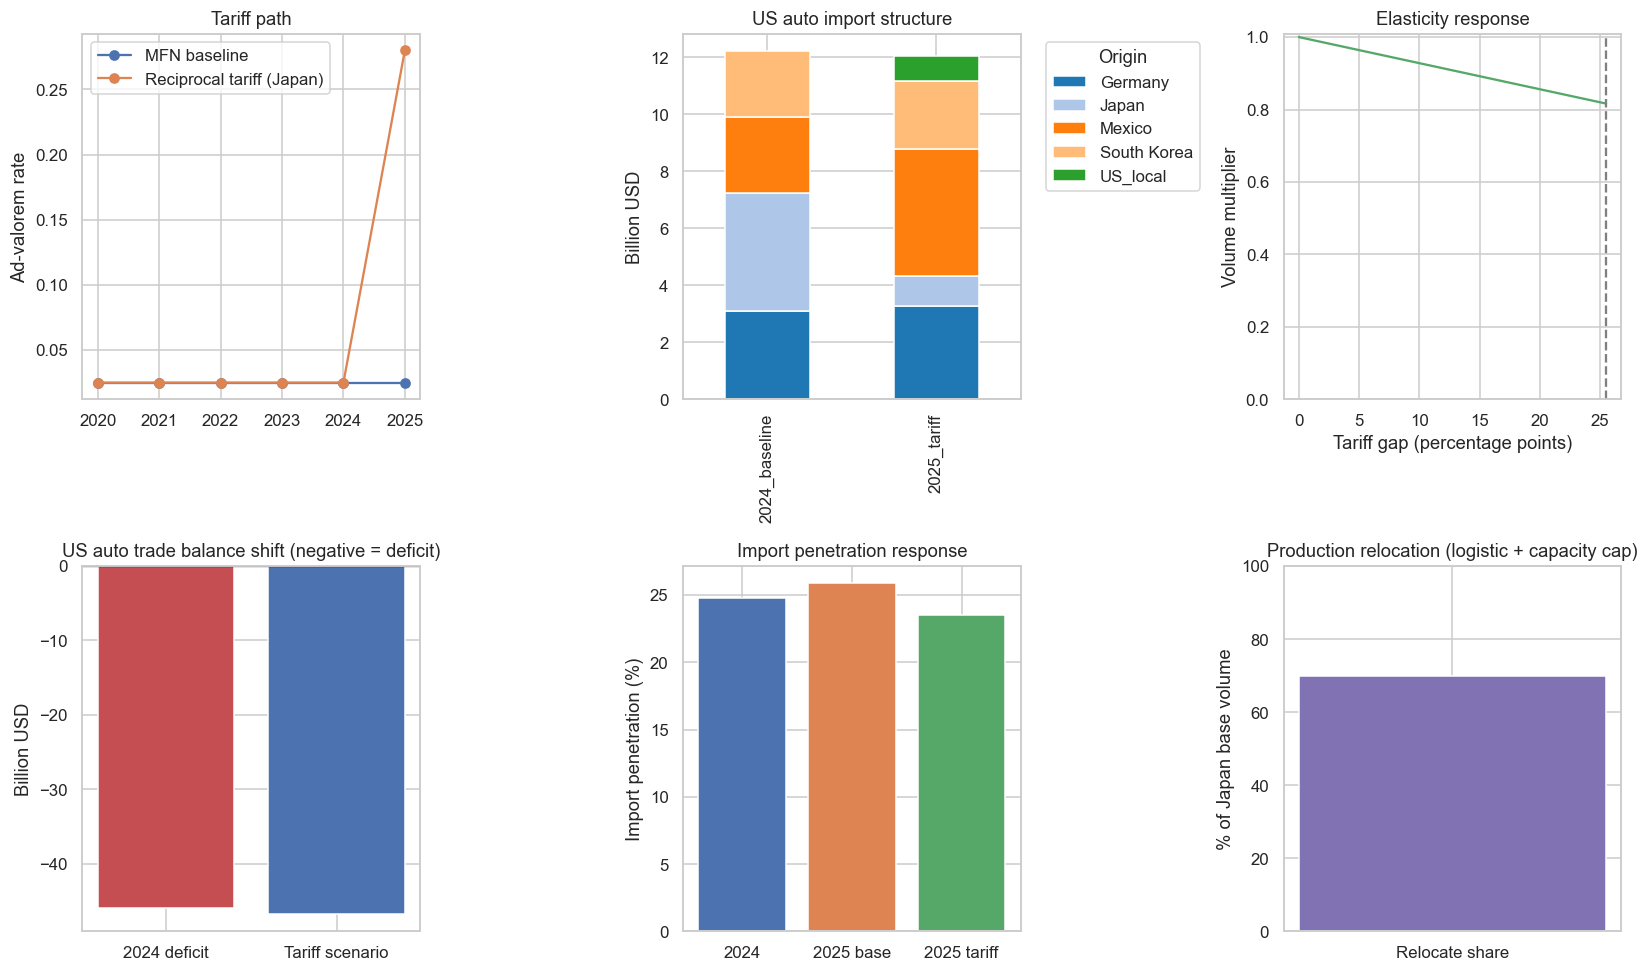

In [5]:

# 可视化：关税路径、进口结构、价格-数量、贸易逆差、渗透率
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# (1) 关税路径
plot_years = list(range(2020, 2025)) + [2025]
base_path = [base_tariff] * len(plot_years)
scenario_path = [base_tariff] * (len(plot_years) - 1) + [new_tariff]
axes[0,0].plot(plot_years, base_path, label='MFN baseline', marker='o')
axes[0,0].plot(plot_years, scenario_path, label='Reciprocal tariff (Japan)', marker='o')
axes[0,0].set_ylabel('Ad-valorem rate')
axes[0,0].set_title('Tariff path')
axes[0,0].legend()

# (2) 进口结构：2024 vs 2025 关税
plot_df = summary_table[["2024_baseline", "2025_tariff"]].T
plot_df.plot(kind='bar', stacked=True, ax=axes[0,1], color=sns.color_palette('tab20'))
axes[0,1].set_ylabel('Billion USD')
axes[0,1].set_title('US auto import structure')
axes[0,1].legend(title='Origin', bbox_to_anchor=(1.05, 1), loc='upper left')

# (3) 价格-数量响应曲线
price_grid = np.linspace(0, new_tariff - base_tariff, 25)
vol_grid = 1 + elasticity * pass_through * price_grid
axes[0,2].plot(price_grid * 100, vol_grid, color='C2')
axes[0,2].axvline((new_tariff - base_tariff) * 100, color='gray', linestyle='--')
axes[0,2].set_xlabel('Tariff gap (percentage points)')
axes[0,2].set_ylabel('Volume multiplier')
axes[0,2].set_title('Elasticity response')
axes[0,2].set_ylim(bottom=0)

# (4) 贸易逆差调整
auto_deficit_2024 = trade_balance.query("Year == 2024 and Category == 'Automobiles'")["Trade_Balance_USD"].iloc[0] / 1e9
imports_delta = scenario_imports.sum() - base_forecast.sum()
trade_balance_scenario = auto_deficit_2024 + imports_delta  # 进口下降 => 逆差收窄
axes[1,0].bar(['2024 deficit', 'Tariff scenario'], [auto_deficit_2024, trade_balance_scenario], color=['C3', 'C0'])
axes[1,0].axhline(0, color='black', linewidth=0.8)
axes[1,0].set_ylabel('Billion USD')
axes[1,0].set_title('US auto trade balance shift (negative = deficit)')

# (5) 渗透率与市场规模
axes[1,1].bar(['2024', '2025 base', '2025 tariff'], [pen_2024*100, pen_2025_base*100, scenario_out['penetration']*100], color=['C0','C1','C2'])
axes[1,1].set_ylabel('Import penetration (%)')
axes[1,1].set_title('Import penetration response')

# (6) 产地转移占比
axes[1,2].bar(['Relocate share'], [scenario_out['relocate']*100], color='C4')
axes[1,2].set_ylim(0, 100)
axes[1,2].set_ylabel('% of Japan base volume')
axes[1,2].set_title('Production relocation (logistic + capacity cap)')

plt.tight_layout()
plt.show()



## 经济传递链与策略启示（结合非关税应对）
- **价格与销量冲击**：关税缺口 25.5 个百分点，按 60% 传导，零售端价格+15.3%；常数弹性 -1.2 对应日系对美直销销量系数约 0.82。
- **产地转移**：逻辑函数在 12% 门槛上迅速上升，受墨西哥现有产能约束，约 65–70% 受冲击量迁移至北美（墨西哥 65%，美国本土 35%），形成“互惠关税→北美原产地累积→绕开关税”的链条。
- **进口结构与渗透率**：2025 关税情景中，日本份额下降、墨西哥与本地化项上升，整体进口渗透率由基准上行改为略降；部分需求转向美国生产，减轻逆差但同时推高消费者价格、缩短车型选择。
- **贸易逆差**：进口缩量使美国汽车逆差小幅收窄；若同步对零部件加征或强化原产地规则，零部件成本上升会抵消部分逆差改善。
- **非关税应对策略**：
  1) **产能再配置**：加速墨西哥及美南工厂的投资节奏，将高关税车型转为北美生产；利用 USMCA 原产地累积提高本地化比例。
  2) **技术标准/认证**：将美国认证路径前移至设计环节，减少重复测试成本；对高认证成本车型优先在北美生产以降低合规摩擦。
  3) **产品结构调整**：提高高毛利 SUV/皮卡在北美的产能配置，低毛利轿车减少对美出口，改为本地 CKD/SKD 组装。
  4) **价格与金融工具**：通过金融补贴、租赁与残值支持平滑终端价格冲击；短期内接受部分利润让渡以稳住市占。

> 扩展：可将 `pass_through`、`elasticity`、`reloc_center/slope`、产能上限设为蒙特卡洛参数，输出进口份额与逆差的置信区间；亦可按品牌/车型细分（利用品牌列）评估中高端与大众车型的差异化冲击。
